In [28]:
import pandas as pd
import numpy as np
from numpy.random import seed
seed(1)
import matplotlib.pyplot as plt
import seaborn as sns
from t2e_utils import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler
palette=sns.color_palette("RdBu_r", 50)
import pickle
import random
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import wtte.wtte as wtte

from keras.models import Sequential, load_model,Model
from keras.initializers import glorot_normal
from keras.layers import Dense,LSTM,GRU,Activation,Masking,BatchNormalization,Lambda,Input
from keras import backend as K
from keras import callbacks
from keras.optimizers import RMSprop,adam,Nadam
from keras.callbacks import History, EarlyStopping, ModelCheckpoint, CSVLogger, ReduceLROnPlateau
import os
plt.style.use('seaborn-muted')
# # np.random.seed(2)
# # pd.set_option("display.max_rows",1000)
%matplotlib inline
%load_ext autoreload
%autoreload 2
import h5py

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


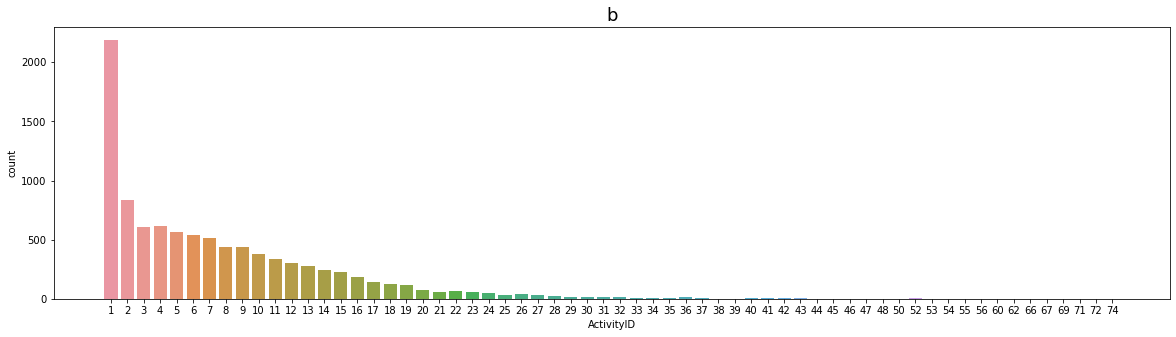

In [29]:
path = '../Tax_paper/data/'
b = os.path.join(path,'bpi_12_w.csv')
b = pd.read_csv(b)

df_dict = {
    'a': None,
    'b': b,
    'c': None,
    'd':None
}
range_dict = {
    'a': range(2,8,1),
    'b': range(2,22,2),
    'c': range(2,12,2),
    'd': range(2,22,2)
}

for key, dataset in df_dict.items():
    if key == 'b':
        plt.figure(figsize=(20,5))
        sns.countplot(dataset.groupby(["CaseID"]).agg({"ActivityID":'count'})["ActivityID"])
        plt.title(key,fontsize=18)
        plt.plot()

In [30]:
# baseline = {}
# for dataset in ['b']:
#     tmp = df_dict[dataset].groupby(["Prefix length"]).apply(lambda x:mean_absolute_error(x['Ground truth times'], x['Predicted times'])/86400).to_dict()
#     tmp = {k:v for k,v in tmp.items() if k in list(range_dict[dataset])}
#     baseline[dataset] = list(tmp.values())
# pickle.dump(baseline, open("baseline.pkl","wb"))

In [31]:
suffix = 6
dataset_preprocessed = preprocess(b,min_length=suffix +1)

In [44]:
X_train, X_test, X_val, y_train, y_test, y_val = smart_split(dataset_preprocessed, 
                                                                     train_perc = 0.7,
                                                                     val_perc = 0.20,
                                                                     suffix = suffix,
                                                                     resolution='s',
                                                                     scaling = False)
print(X_train.shape, y_train.shape, X_val.shape,y_val.shape , X_test.shape, y_test.shape)

(2589, 6, 8) (2589, 2) (647, 6, 8) (647, 2) (1072, 6, 8) (1072, 2)


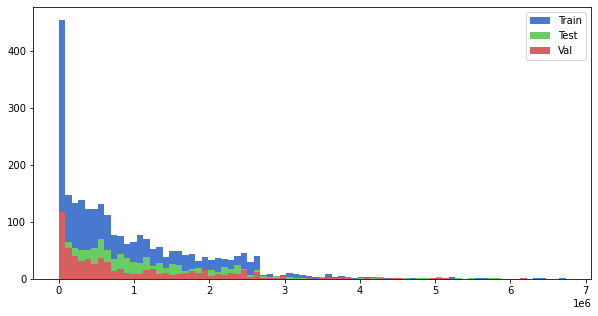

In [45]:
bins = np.arange(0,y_train.max()+86400, 86400)

plt.figure(figsize=(10,5))
plt.hist(y_train[:,0], bins = bins,label="Train");

plt.hist(y_test[:,0], bins = bins, label="Test");
plt.hist(y_val[:,0], bins = bins,label="Val");
plt.legend()
plt.show()

## Model

In [48]:
def train_notebook(X_train, y_train, X_val, y_val):
    tte_mean_train = np.nanmean(y_train[:,0].astype('float'))
    mean_u = np.nanmean(y_train[:,1].astype('float'))
    init_alpha = -1.0/np.log(1.0-1.0/(tte_mean_train+1.0) )
    init_alpha = init_alpha/mean_u
    history = History()
    cri = 'val_loss'
    csv_logger = CSVLogger('training.log', separator=',', append=False)
    es = EarlyStopping(monitor=cri, mode='min', verbose=True, patience=100, restore_best_weights=True)
    mc = ModelCheckpoint('best_model_suff'+str(suffix)+'.h5', monitor=cri, mode='min', verbose=True, save_best_only=True, save_weights_only=True)
    lr_reducer = ReduceLROnPlateau(monitor=cri, factor=0.5, patience=10, verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
    n_features = X_train.shape[-1]

    main_input = Input(shape=(None, n_features), name='main_input')
#     mask_input = Masking(mask_value=0, name='mask_input')(main_input)

    l1 = GRU(64, activation='tanh', kernel_initializer=glorot_normal(seed=42), recurrent_dropout=0.2,return_sequences=True)(main_input)
    b0 = BatchNormalization()(l1)
    l11 = GRU(16, activation='tanh',kernel_initializer=glorot_normal(seed=42), recurrent_dropout=0.2,return_sequences=False)(b0)
    b1 = BatchNormalization()(l11)
    l2 = Dense(2, kernel_initializer=glorot_normal(seed=42), name='Dense')(b1)
    b2 = BatchNormalization()(l2)
    output = Lambda(wtte.output_lambda, arguments={"init_alpha":init_alpha,"max_beta_value":100, "scalefactor":0.5})(b2)
    loss = wtte.loss(kind='continuous',reduce_loss=False).loss_function
    model = Model(inputs=[main_input], outputs=[output])
    model.compile(loss=loss, optimizer=Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004, clipvalue=3))

    mg_train = batch_gen(X_train, y_train)
    mg_val = batch_gen(X_val, y_val)
    model.fit_generator(mg_train, 
                    epochs=500,
                    steps_per_epoch = ceil(len(X_train) / batch_size),
                    validation_data=(mg_val),
                    validation_steps= ceil(len(X_val) / batch_size),
                    verbose=True,
                    callbacks=[history,mc,es,csv_logger]
                   )
    return model
model = train_notebook(X_train, y_train, X_val, y_val)

Epoch 1/500
21/21 [==============================] - 1s 69ms/step - loss: 1.3778 - val_loss: 0.9190

Epoch 00001: val_loss improved from inf to 0.91898, saving model to best_model_suff6.h5
Epoch 2/500
21/21 [==============================] - 0s 11ms/step - loss: 1.2955 - val_loss: 0.9489

Epoch 00002: val_loss did not improve from 0.91898
Epoch 3/500
21/21 [==============================] - 0s 9ms/step - loss: 1.2465 - val_loss: 0.9392

Epoch 00003: val_loss did not improve from 0.91898
Epoch 4/500
21/21 [==============================] - 0s 10ms/step - loss: 1.1945 - val_loss: 0.9398

Epoch 00004: val_loss did not improve from 0.91898
Epoch 5/500
21/21 [==============================] - 0s 9ms/step - loss: 1.1845 - val_loss: 0.9607

Epoch 00005: val_loss did not improve from 0.91898
Epoch 6/500
21/21 [==============================] - 0s 10ms/step - loss: 1.1792 - val_loss: 0.9628

Epoch 00006: val_loss did not improve from 0.91898
Epoch 7/500
21/21 [==============================] - 

21/21 [==============================] - 0s 13ms/step - loss: 1.1577 - val_loss: 1.0574

Epoch 00054: val_loss did not improve from 0.91898
Epoch 55/500
21/21 [==============================] - 0s 13ms/step - loss: 1.1587 - val_loss: 1.0438

Epoch 00055: val_loss did not improve from 0.91898
Epoch 56/500
21/21 [==============================] - 0s 13ms/step - loss: 1.1558 - val_loss: 1.0525

Epoch 00056: val_loss did not improve from 0.91898
Epoch 57/500
21/21 [==============================] - 0s 14ms/step - loss: 1.1535 - val_loss: 1.0415

Epoch 00057: val_loss did not improve from 0.91898
Epoch 58/500
21/21 [==============================] - 0s 13ms/step - loss: 1.1524 - val_loss: 1.0352

Epoch 00058: val_loss did not improve from 0.91898
Epoch 59/500
21/21 [==============================] - 0s 13ms/step - loss: 1.1547 - val_loss: 1.0477

Epoch 00059: val_loss did not improve from 0.91898
Epoch 60/500
21/21 [==============================] - 0s 13ms/step - loss: 1.1546 - val_loss: 1

11.057416364140057


0.000000         283
316038.523408      2
286031.549649      2
332334.204368      2
324235.682530      2
                ... 
133685.802098      1
309065.093945      1
332170.064171      1
187707.695411      1
304622.062092      1
Name: predicted_mode, Length: 784, dtype: int64

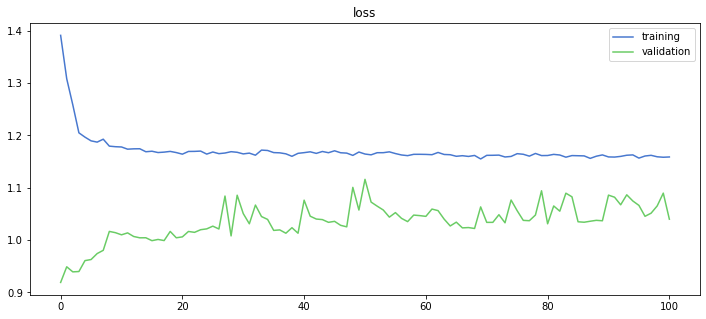

In [49]:
model.load_weights('best_model_suff'+str(suffix)+'.h5')
history = pd.read_csv('training.log', sep=',', engine='python')

test_result_df, mae = evaluating(X_test,y_test, model,resolution = 's')
print(mae)
plt.figure(figsize = (12,5));
plt.plot(history['loss'], label='training');
plt.plot(history['val_loss'],label='validation');
plt.title('loss');
plt.legend();
test_result_df["predicted_mode"].value_counts()

In [9]:
# # build the model: 
# print('Build model...')
# n_features = X_train.shape[-1]
# main_input = Input(shape=(None, n_features), name='main_input')
# # train a 2-layer LSTM with one shared layer
# l1 = LSTM(128, implementation=2, kernel_initializer='glorot_uniform', return_sequences=True, dropout=0.2)(main_input) # the shared layer
# b1 = BatchNormalization()(l1)
# l2_2 = LSTM(128, implementation=2, kernel_initializer='glorot_uniform', return_sequences=False, dropout=0.2)(b1) # the layer specialized in time prediction
# b2_2 = BatchNormalization()(l2_2)
# time_output = Dense(1, kernel_initializer='glorot_uniform', name='time_output')(b2_2)

# model = Model(inputs=[main_input], outputs=[time_output])

# opt = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004, clipvalue=3)

# model.compile(loss={'time_output':'mae'}, optimizer=opt)
# early_stopping = EarlyStopping(monitor='val_loss', patience=42)
# model_checkpoint = ModelCheckpoint('output_files/models/model_{epoch:02d}-{val_loss:.2f}.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto')
# lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
# print(model.summary())
# model.fit(X_train, {'time_output':y_train[:,0]}, validation_data=(X_val,y_val[:,0]), verbose=2, callbacks=[early_stopping, model_checkpoint, lr_reducer], batch_size=128, epochs=500)

###############################################################################################################################

No handles with labels found to put in legend.


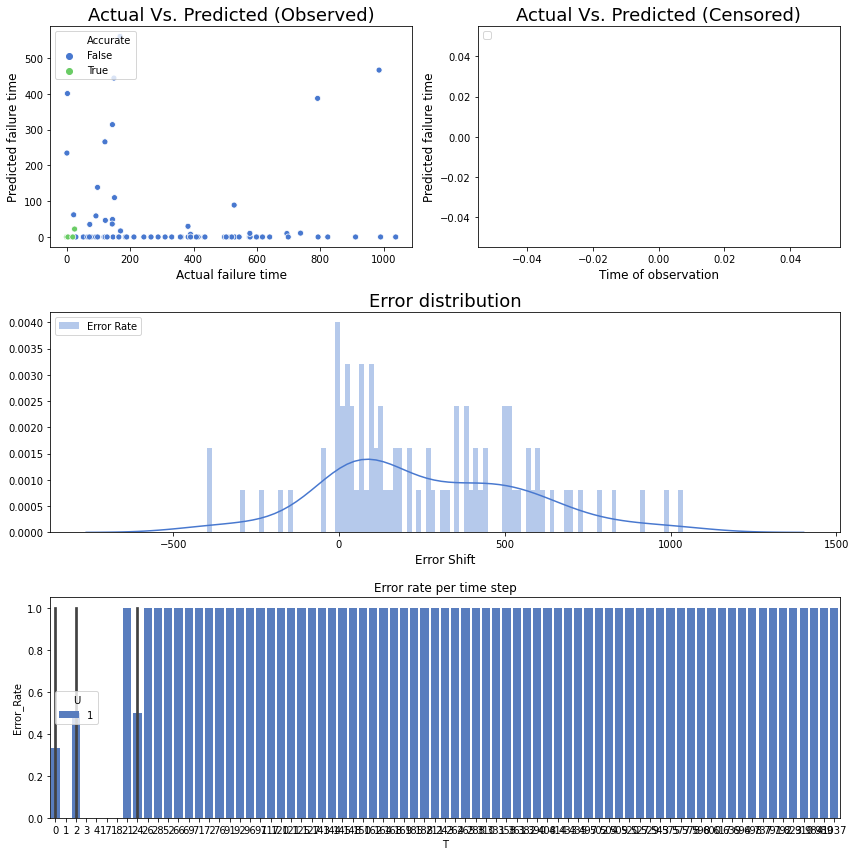

In [48]:
plot_predictions_insights(test_result_df)

In [50]:
# mg_test = batch_gen_test(X_test)
# nb_samples = len(X_test)
# test_predict = model.predict_generator(mg_test, steps= ceil(len(X_test) / batch_size))
# test_results_df = pd.DataFrame(y_test[:,0], columns=['T'])
# test_results_df['predicted_mode'] =  test_predict
# mae = mean_absolute_error(test_results_df['T'], test_results_df['predicted_mode']) / 24
# print(mae, test_results_df)

# plt.figure(figsize = (12,5));
# plt.plot(history['loss'], label='training');
# plt.plot(history['val_loss'],label='validation');
# plt.title('loss');
# plt.legend();
# test_result_df["predicted_mode"].value_counts()

No handles with labels found to put in legend.


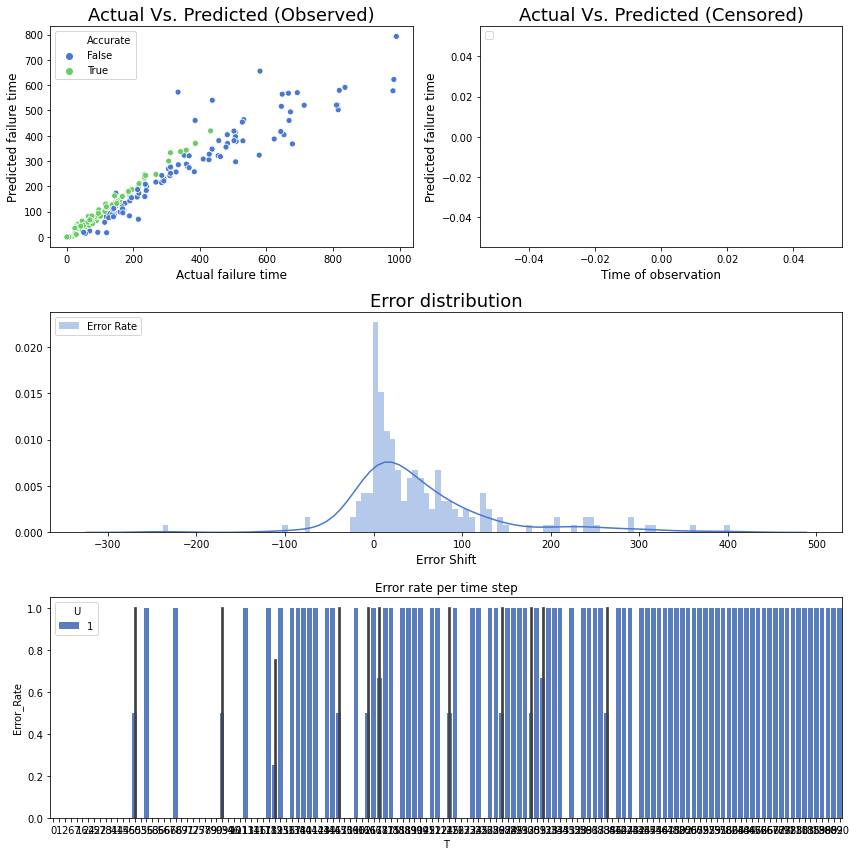

In [29]:
test_result_df, mae = evaluating(X_train,y_train, model)
plot_predictions_insights(test_result_df)

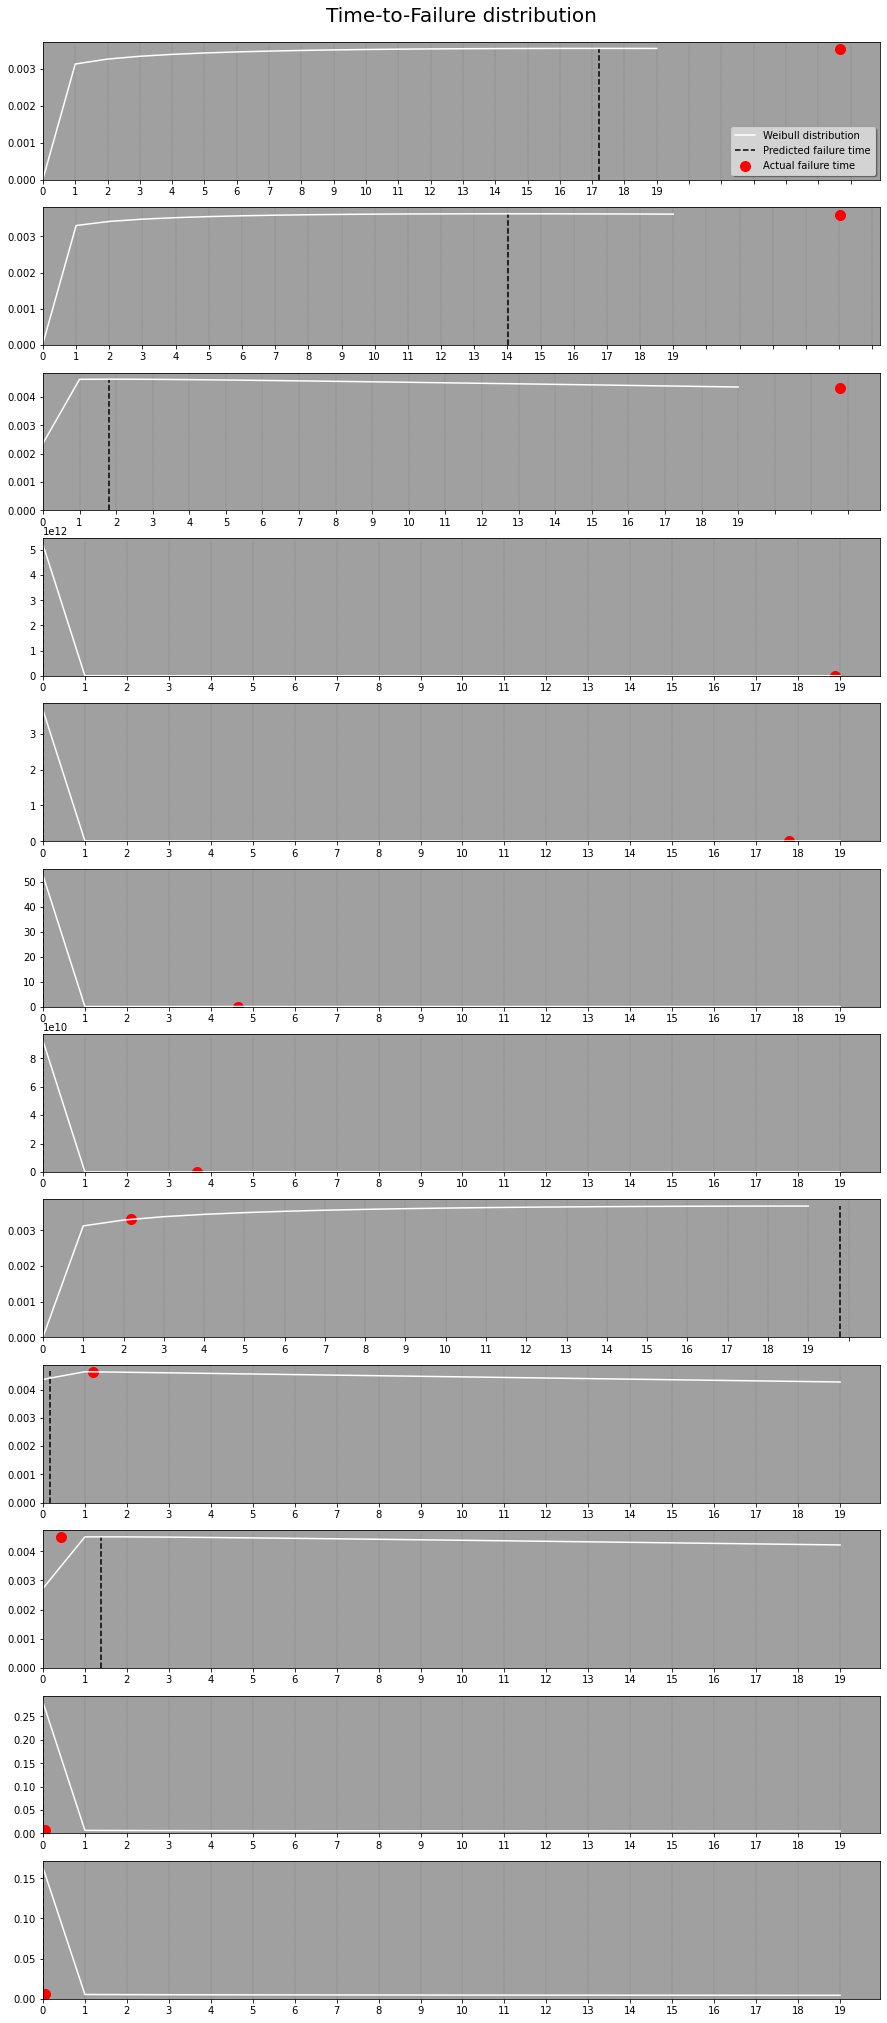

In [306]:
from t2e_utils import *
plot_top_predictions(test_result_df,15,top_feature="T",ascending=False, U=1,accurate=True)

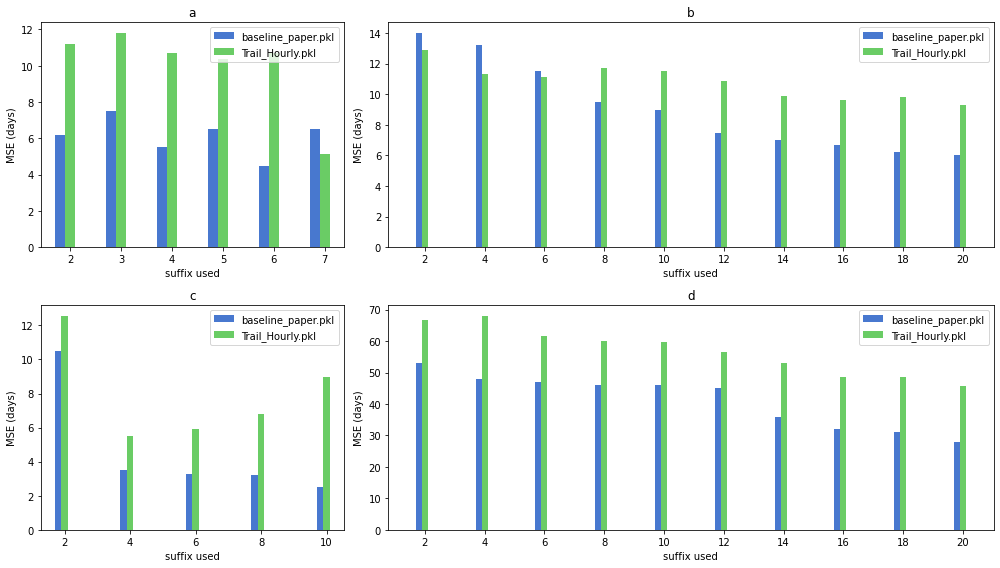

In [24]:
cases = ["baseline_paper.pkl","Trail_Hourly.pkl"]

fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 2]},figsize=(14,8))

for i,dataset in enumerate(['a','b','c','d']):
    if dataset == 'a':
        plt.sca(ax[0][0])
    elif dataset == 'b':
        plt.sca(ax[0][1])
    elif dataset == 'c':
        plt.sca(ax[1][0])
    elif dataset == 'd':
        plt.sca(ax[1][1])

    X = np.array(range_dict[dataset])
    steps = [-0.2, 0, 0.2]
    for j,case in enumerate(cases):
        data = list(pickle.load(open(case,"rb")).values())[i];
        plt.bar(X+steps[j], data, width = 0.2, label=case);
    
    plt.xticks(range_dict[dataset])
    plt.legend();
    plt.xlabel("suffix used")
    plt.ylabel("MSE (days)")
    plt.title(dataset)
plt.tight_layout()
plt.show()

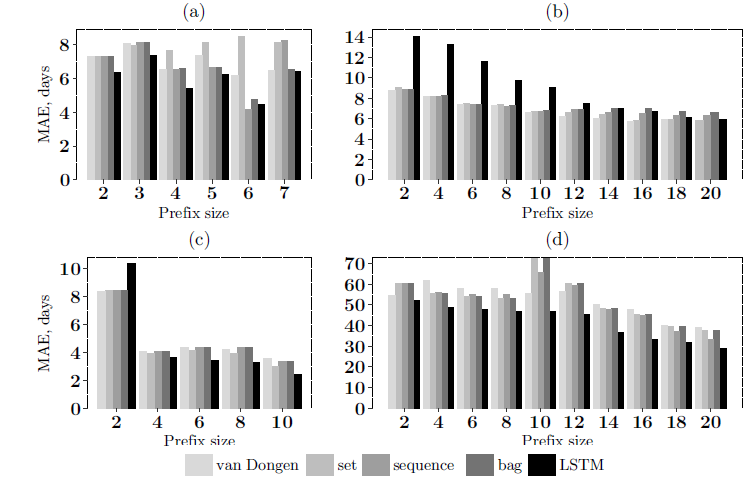